# Machine Learning Test

You have 3 days to solve the test from the moment you receive it. 

Show us your skills !

## Problem description

You are hired as a Data Scientist at a top real state company in California, and you first job is to develop an ML model to predict house prices. This model will then be used as an investment tool in your company, to buy houses when their price is lower than their real value or negotiating overprices.

## Get the data

Over the years, your company has been gathering some data that you can start using. It is available in the following link: https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/housing.tgz

## Imports

In [20]:
# Data Analysis
import pandas as pd
import numpy as np
import math

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.base import BaseEstimator, TransformerMixin

# Model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
import  statsmodels.formula.api as sm

#Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor ,RANSACRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor

# Ignore noise warning
import warnings
warnings.filterwarnings('ignore')

# Work with pickles
import pickle as pkl

pd.set_option('display.max_column', None)

## Explore the data

Load the data to explore it. Try to answer the following questions:

- How many features has the dataset ? What type are they ?
- How many samples are in the dataset ? 
- Are there missing values ? 
- Is there any correlation between features ?

In [21]:
housing_df = pd.read_csv('data/housing.csv')
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### How many features has the dataset? What type are they?

In [22]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### How many samples are in the dataset? 

In [23]:
housing_df.shape

(20640, 10)

### Are there missing values?

In [5]:
housing_df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Let's check if there are duplicated values and outliers

In [6]:
housing_df.duplicated().sum()

0

In [7]:
stats = housing_df.describe().transpose()
stats["IQR"] = stats["75%"] - stats["25%"]
outliers = pd.DataFrame(columns=housing_df.columns)
for col in stats.index:
    iqr = stats.at[col, 'IQR']
    cutoff = iqr * 1.5
    lower = stats.at[col, '25%'] - cutoff
    upper = stats.at[col, '75%'] + cutoff
    results = housing_df[(housing_df[col] < lower) | (housing_df[col] > upper)].copy()
    results['Outlier'] = col
    outliers = outliers.append(results)
print(housing_df.shape)
print(outliers.shape)

(20640, 10)
(6726, 11)


In [8]:
print ('The', 6726/20640*100,'% are outlying values')

The 32.58720930232558 % are outlying values


### How much variablility this dataset's features have?

In [9]:
housing_df.nunique()

longitude               844
latitude                862
housing_median_age       52
total_rooms            5926
total_bedrooms         1923
population             3888
households             1815
median_income         12928
median_house_value     3842
ocean_proximity           5
dtype: int64

### Let's see some metrics statistics

In [16]:
housing_df.describe().to_csv('data/output_csv/descriptive_stats.csv')

In [17]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Is there any correlation between features?

In [18]:
housing_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


## Visualize the data

Try to come up with the best possible visualizations (most informative) for the dataset.

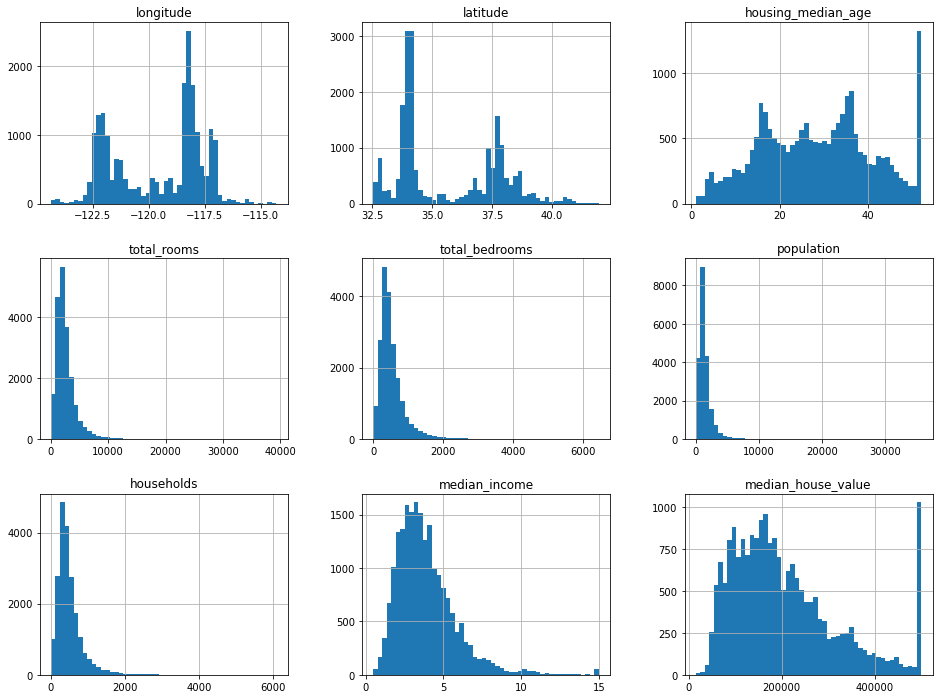

In [19]:
housing_df.hist(figsize=(16,12), bins=50)
plt.savefig('images/output_images/housing_hist.png')
sns.set_context("talk")
plt.show()

**As we see most variables' distibutions are right-skewed and present outliers**

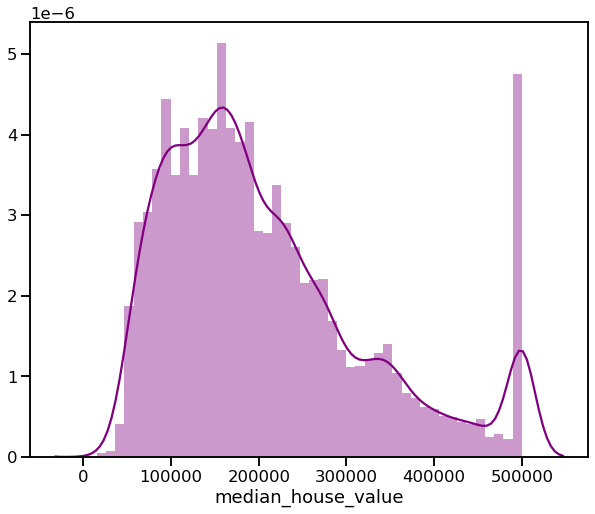

In [20]:
plt.figure(figsize=(10,8))
sns.distplot(housing_df['median_house_value'],color='purple')
plt.savefig('images/output_images/value_dist.png')
sns.set_context("talk")
plt.show()

**Focusing on the median house value, we see its distribution is not as right-skewed as other features, but and presents quite extreme outliers**

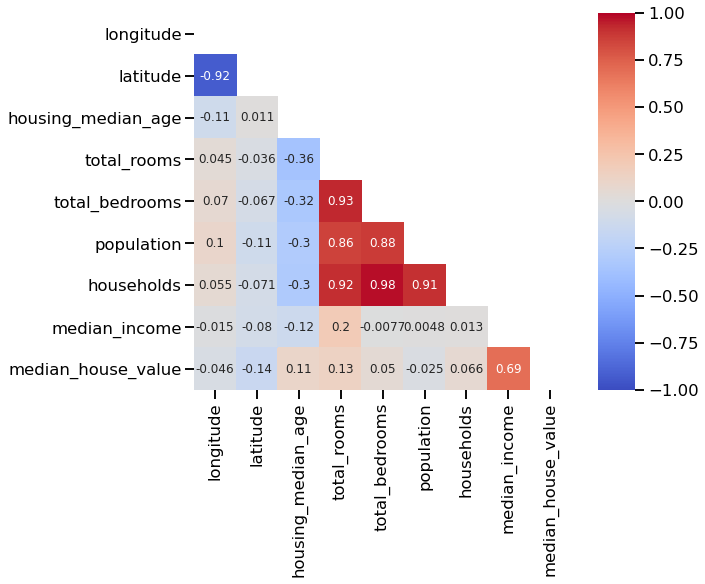

In [21]:
mask = np.triu(np.ones_like(housing_df.corr(), dtype=np.bool))
plt.figure(figsize=(16,8), constrained_layout=True)
sns.heatmap(housing_df.corr(),square=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask, annot=True, annot_kws={"size": 12}) 
plt.savefig('images/output_images/housing_corr.png')
sns.set_context("talk")
plt.show()

**The greatest correlations are between:**

* `total_rooms` and `total_bedrooms`, `total_rooms` y `population`, y `total_rooms` y `households`

* `total_bedrooms` and `population`, and `total_bedrooms` and `households`

* `population` and `households`

* `median_income` and `median_hause_value` (I can't use it though, as its a feature derived from the target so it could led to bias)

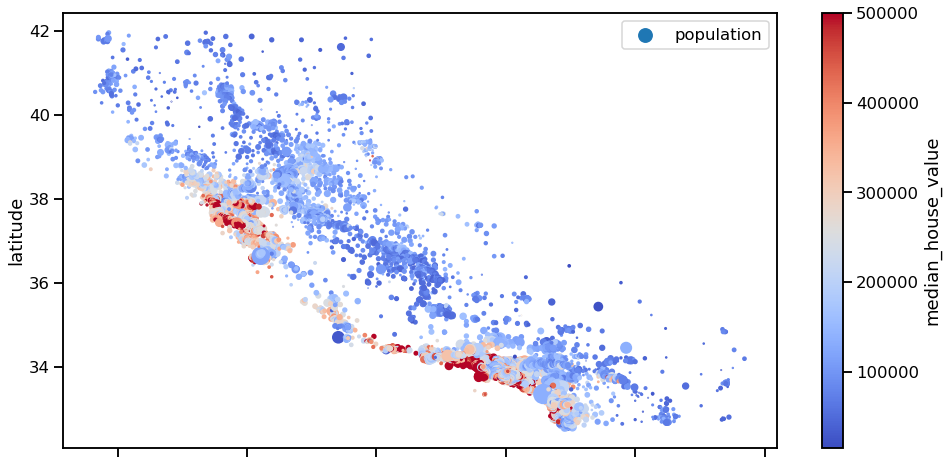

In [22]:
housing_df.plot(kind="scatter", x="longitude", y="latitude", s=housing_df["population"]/100, 
             label="population", c="median_house_value", cmap='coolwarm', colorbar=True, figsize=(16,8))
plt.savefig('images/output_images/housing_pop_per_loc.png')
sns.set_context("talk")
plt.show()

**Location does not especially correlate with house value, but in this plot we can see how prices in big cities and close to the sea (*San Francisco* and vicinity, *Los Angeles* and vicinity, as well as *San Diego* and surroundings) keep most of the houses with highest market value**

## Feature engineering

Try to combine several features into new ones and see if they have better correlation.

In [10]:
housing_df_newfeat = housing_df.copy()

In [11]:
housing_df_newfeat["income_per_house_val"] = housing_df_newfeat["median_income"]/housing_df_newfeat["median_house_value"]

housing_df_newfeat["rooms_per_bedroom"] = housing_df_newfeat["total_rooms"]/housing_df_newfeat["total_bedrooms"]
housing_df_newfeat["rooms_per_population"] = housing_df_newfeat["total_rooms"]/housing_df_newfeat["population"]
housing_df_newfeat["rooms_per_household"]=housing_df_newfeat["total_rooms"]/housing_df_newfeat["households"]

housing_df_newfeat["bedrooms_per_population"] = housing_df_newfeat["total_bedrooms"]/housing_df_newfeat["population"]
housing_df_newfeat["bedrooms_per_household"] = housing_df_newfeat["total_bedrooms"]/housing_df_newfeat["households"]

In [12]:
corr = housing_df_newfeat.corr()
print(corr['median_house_value'].sort_values(ascending = False))

median_house_value         1.000000
median_income              0.688075
rooms_per_bedroom          0.383920
rooms_per_population       0.209482
rooms_per_household        0.151948
total_rooms                0.134153
housing_median_age         0.105623
bedrooms_per_population    0.069896
households                 0.065843
total_bedrooms             0.049686
population                -0.024650
longitude                 -0.045967
bedrooms_per_household    -0.046739
latitude                  -0.144160
income_per_house_val      -0.518606
Name: median_house_value, dtype: float64


**Greater correlation with target, regardless of its sign, than its predecesors:**

* `rooms_per_bedroom`
* `rooms_per_population`
* `rooms_per_household`
* `bedrooms_per_population`

**Lesser correlation with target, regardless of its sign, than its predecesors:**
* `population_per_household`
* `bedrooms_per_household`

## Prepare the data for ML algorithms

Using [Scikit-learn](https://scikit-learn.org/stable/) build a pipeline for data preparation. The pipeline should include:

- Data cleaning
- Encoding of categorical features
- Feature scaling

### Building the pipeline

In [24]:
housing_df_newfeat = housing_df.copy()

In [25]:
X = housing_df_newfeat.drop(['median_house_value'], axis=1)
y = housing_df_newfeat['median_house_value']

**I'll make a custom transformer to create only the new features with higher correlations with median_house_value than the original features they're built upon.**

In [26]:
rooms_ix,bedrooms_ix,population_ix,household_ix=3,4,5,6

class new_features(BaseEstimator, TransformerMixin):
    def __init__(self, add_rooms_per_bedroom = True):
        self.add_rooms_per_bedroom = add_rooms_per_bedroom
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household=X[:,rooms_ix]/X[:,household_ix]
        rooms_per_population=X[:,rooms_ix]/X[:,population_ix]
        bedrooms_per_population=X[:,bedrooms_ix]/X[:,population_ix]
        rooms_per_bedroom = X[:, rooms_ix] / X[:, bedrooms_ix]
        if self.add_rooms_per_bedroom:
            rooms_per_bedroom = X[:, rooms_ix] / X[:, bedrooms_ix]
            return np.c_[X, rooms_per_household, rooms_per_population, bedrooms_per_population, rooms_per_bedroom]
        else:
            return np.c_[X, rooms_per_household, rooms_per_population, bedrooms_per_population, rooms_per_bedroom]

In [27]:
numeric_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
                    'households', 'median_income']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('new_features', new_features()),
                                      ('scaler', StandardScaler())])

categorical_features = ['ocean_proximity']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessing_pipeline = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                          ('cat', categorical_transformer, categorical_features)])

In [28]:
X_prep = preprocessing_pipeline.fit_transform(X)

## Train some models

Train a list of models on default parameters to get a quick idea of the performance of each one with the dataset. Compare their performance and keep the top 3-5 models for the next step.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(16512, 17) (16512,) (4128, 17) (4128,)


In [30]:
class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
        clf = GridSearchCV(self.model,
                           self.hyperparameters,
                           cv=strat_k_fold,
                           verbose=2,
                           n_jobs=-1,
                           refit=True)
        
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

### BaggingRegressor

#### GridSearch Pipeline

In [ ]:
param_grid =  {'base_estimator': [None],
               'max_features': [0.75, 1.0],
               'n_estimators' : [1800, 2000],
               'bootstrap_features': [False],
               'bootstrap': [True, False],
               'oob_score': [False] 
            }

Bagging = BaggingRegressor()
Bagging_GridSearch = GridSearch(X_train,y_train,Bagging,param_grid)
Prediction_Bagging = Bagging_GridSearch.BestModelPridict(X_test)
print('prediction on test set is:' ,r2_score(y_test, Prediction_Bagging))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


### GradientBoostingRegressor

#### GridSearch Pipeline

In [ ]:
param_grid =  {'loss':['ls', 'lad'],
               'learning_rate': [0.075],
               'max_depth': [3, 80], 
               'n_estimators' : [800, 2000],
               'min_samples_leaf': [1, 18],
               'min_samples_split': [5, 13],
               'max_features':['auto'],
               'criterion': ['friedman_mse', 'mse'],
               'subsample':[0.7, 0.9]
              }

model_GB = GradientBoostingClassifier()
GB_GridSearch = GridSearch(X_train,y_train,model_GB,param_grid)
Prediction_GB = GB_GridSearch.BestModelPridict(X_test)
print('prediction on test set is:' ,r2_score(y_test, Prediction_GB))

### KNeighborsRegressor

#### GridSearch Pipeline

In [51]:
param_grid =  {'weights': ['distance'],
               'n_neighbors': [6, 14], 
               'algorithm': ['auto', 'kd_tree'],
               'metric' : ['minkowski', 'manhattan'],
               'leaf_size': [30, 60],
            }

KN_regressor = KNeighborsRegressor()
KN_regressor_GridSearch = GridSearch(X_train,y_train,KN_regressor,param_grid)
Prediction_KN_regressor = KN_regressor_GridSearch.BestModelPridict(X_test)
print('prediction on test set is:' ,r2_score(y_test, Prediction_KN_regressor))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.1s finished


Best: 0.758317 using {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'n_neighbors': 14, 'weights': 'distance'}
prediction on test set is: 0.7550251033645344


In [ ]:
grid_GBR = pd.DataFrame(grid.cv_results_)
grid_GBR.to_csv('data/output_csv/grid_GBR.csv')
grid_GBR.sort_values(by='rank_test_score', axis=0).head(2)

### RandomForestRegressor

#### GridSearch Pipeline

In [ ]:
param_grid =  {'criterion': ['mse'],
               'max_depth': [None, 100], 
               'max_features': ['auto', 'log2'],
               'n_estimators' : [2000],
               'min_samples_leaf': [1, 2],
               'min_samples_split': [2, 4],
               'bootstrap': [True, False],
               'oob_score': [False] 
            }

RFR = RandomForestRegressor
RFR_GridSearch = GridSearch(X_train,y_train,RFR,param_grid)
Prediction_RFR = RFR_GridSearch.BestModelPridict(X_test)
print('prediction on test set is:' ,r2_score(y_test, Prediction_RFR))

## Build an ensemble using the Pipeline

**I had to use de results of GridSearch in test_ml notebook as haven't been able to finish executing the previous pipelines**

In [33]:
reg1 = BaggingRegressor(base_estimator = None, bootstrap = True, bootstrap_features = False, 
                        max_features = 0.75, n_estimators = 2000, oob_score = False)
reg2 = KNeighborsRegressor(algorithm = 'auto', leaf_size = 30, metric = 'manhattan', n_neighbors = 14, 
                           weights = 'distance')
reg3 = GradientBoostingRegressor(criterion = 'mse', learning_rate = 0.075, loss = 'ls', max_depth = 3, 
                                 max_features = 'auto', min_samples_leaf = 1, min_samples_split = 13, 
                                 n_estimators = 2000, subsample = 0.9)
reg4 = RandomForestRegressor(bootstrap = False, criterion = 'mse', max_depth = None, max_features = 'log2', 
                             min_samples_leaf = 1, min_samples_split = 2, n_estimators = 2000, oob_score = False)

estimators=[('BaggingRegressor', reg1), ('KNeighborsRegressor', reg2), ('GradientBoostingRegressor', reg3), ('RandomForestRegressor', reg4)]


In [ ]:
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
ensemble = VotingRegressor(estimators)
results = cross_val_score(ensemble, X_train,y_train, cv=strat_k_fold, scoring='r2', n_jobs=-1)
print('R2 on train: ',results)
ensemble_model = ensemble.fit(X_train,y_train)
ensemble_pred = ensemble_model.predict(X_test)
print('R2 on test:' ,r2_score(y_test, ensemble_pred))

## Optional

For extra points try to:

- Implement custom transformers for feature selection and feature engineering.
- Include the data preparation and custom transformers in the fine-tuning pipeline to come up with the best set of features and data preparation strategies.
- Perform error analysis to select the models that make the most diverse type of errors for the ensambling.
- Do anything that teach us something new !

In [ ]:
# show your skills !